## Домашнее задание 3

Стребежев Игорь

In [1]:
%%html
<style>video{width:480px;height:480px}</style>

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib as mpl
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 8, 8

In [3]:
def split(df):
    Y = df.label.values
    X = df[df.columns.drop('label')].as_matrix()
    return X, Y

df = pd.read_csv(f'spambase_old.csv')
_, Y = split(df)

### task 1

Постройте $\texttt{Precision-recall}$ и $\texttt{ROC}$ кривые для правила типа $\texttt{threshold}\ (x_i \ge a)$ по трем последним признакам (`capital_run_length_average`, `capital_run_length_longest`,
`capital_run_length_total`)

$$ TPR = \frac{TP}{TP + FN},\quad FPR = \frac{TN}{TN + FN} $$

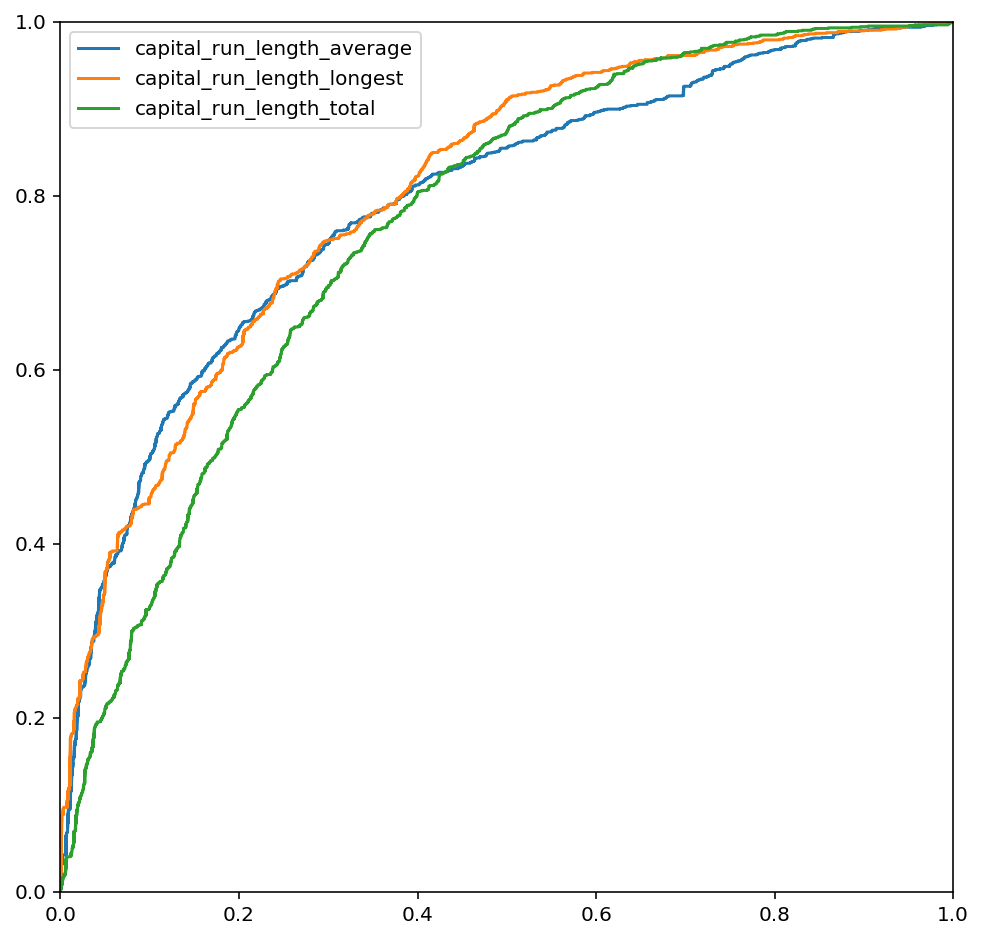

In [95]:
def roc(xs, ys):
    # truthy ys, by descending order of xs
    tys = ys[np.flipud(np.argsort(xs))]
    TPR = np.cumsum(tys) / tys.sum()
    
    # false ys are 1 now
    fys = 1 - tys
    FPR = np.cumsum(fys) / fys.sum()
    
    inds = np.argsort(FPR)
    return FPR[inds], TPR[inds]


columns = [ 'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total', ]

for col in columns:
    plt.plot(*roc(df[col].values, Y), label=col)

plt.xlim([0, 1])
plt.ylim([0, 1])    
plt.legend()

$$ Recall = \frac{TP}{TP + FN},\quad Precision = \frac{TP}{TP + FP} $$

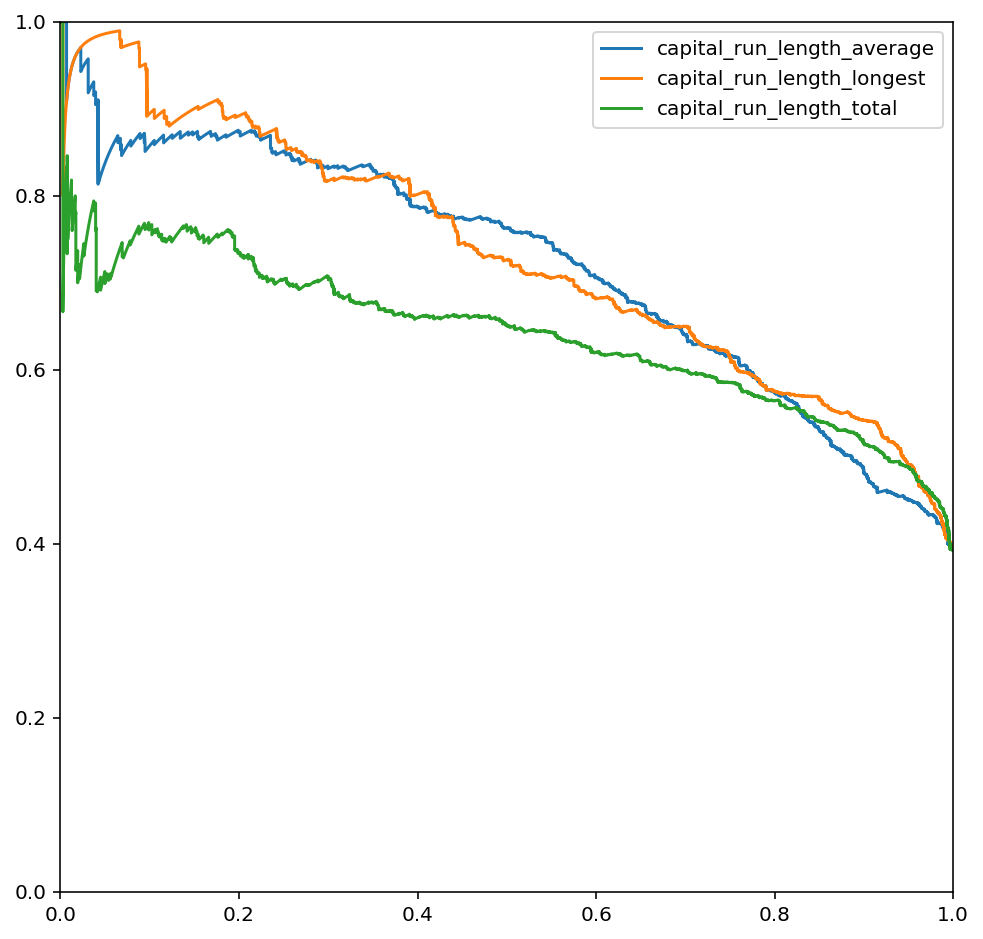

In [134]:
def precision_recall(xs, ys):
    # truthy ys, by descending order of xs
    tys = ys[np.flipud(np.argsort(xs))]
    recall = np.cumsum(tys) / tys.sum()
    
    # false ys are 1 now
    fys = 1 - tys
    precision = np.cumsum(tys) / (np.cumsum(tys) + np.cumsum(fys))
    
    inds = np.argsort(recall)
    return recall[inds], precision[inds]


columns = [ 'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total', ]

for col in columns:
    plt.plot(*precision_recall(df[col].values, Y), label=col)

plt.xlim([0, 1])
plt.ylim([0, 1])    
plt.legend()

### task 2

Посчитайте $\texttt{AUC}$ для правил типа $\texttt{threshold}$ для всех признаков и найдите 10 лучших.

AUC можно посчитать спомощью [trapezoidal rule](http://en.wikipedia.org/wiki/Trapezoidal_rule).

In [96]:
aucs = [ (col, np.trapz(*roc(df[col].values, Y)))
            for col in df.columns.drop('label') ]

sorted(aucs, key=lambda p: p[1])[:-11:-1]

[('word_freq_hp', 0.6813715426952462),
 ('word_freq_george', 0.649205855259593),
 ('word_freq_hpl', 0.6440999202681468),
 ('word_freq_1999', 0.6093750725714684),
 ('word_freq_labs', 0.582266397281376),
 ('word_freq_650', 0.5737398883754055),
 ('word_freq_85', 0.5730829907960024),
 ('word_freq_technology', 0.5725027286872112),
 ('word_freq_edu', 0.5701953043357098),
 ('word_freq_lab', 0.5649744935479127)]

### task 3

Реализуйте алгоритмы построения дерева с критерием информационного выигрыша и
критерием Джини и определению класса по мажоритарному классу в листе. Найдите
оптимальную глубину дерева в обоих случаях (в отрезке 2-10).

In [112]:
def H(Y, R, Rsize):
    if Rsize <= 1:
        return 0
    freqs = np.bincount(Y[R]) / Rsize
    return 0 if (freqs == 0).any() else (freqs * np.log2(freqs)).sum()


def IG(Y, R):
    Rsize1 = R.sum()
    Rsize0 = Y.size - Rsize1
    return (Rsize1 / Y.size) * H(Y, R,  Rsize1) +\
           (Rsize0 / Y.size) * H(Y, ~R, Rsize0) #-H(X, X.size)


def Gini(Y, R):
    p = Y[R].sum() / Y.size
    return 2 * p * (1 - p)


def colThreshold(Y, X, estimate, amaxmin):
    igs = [estimate(Y, X >= v) for v in X]
    best = amaxmin(np.array(igs))
    return X[best], igs[best]


def bestThreshold(D, Y, estimate, amaxmin):
    inCols = [colThreshold(Y, D[:, c], estimate, amaxmin) for c in range(D.shape[1])]
    vals, igs = zip(*inCols)
    col = amaxmin(np.array(igs))
    return col, vals[col], igs[col]


def tree(D, Y, h, estimate, amaxmin, sp=''):
    if h < 0 or len(Y) == 0: return
    
    # has the only class, or height is over
    stats = np.bincount(Y)
    if (h == 0) or (stats == Y.size).any():
#         print(sp, 'leaf', Y.size, stats, stats.argmax())
        return stats.argmax()
    
    col, threshold, ig = bestThreshold(D, Y, estimate, amaxmin)
    idx = D[:, col] >= threshold
#     print(sp, D.shape, Y.size, (col, threshold, ig), idx.sum())
    
    ltree = tree(D[ idx], Y[ idx], h - 1, estimate, amaxmin, sp + '  ')
    rtree = tree(D[~idx], Y[~idx], h - 1, estimate, amaxmin, sp + '  ')
    return ltree, rtree, col, threshold


def predict(D, tree):
    if isinstance(tree, tuple):
        ltree, rtree, col, threshold = tree
        
        idx = D[:, col] >= threshold
        res = np.zeros(D.shape[0])
        res[ idx] = predict(D[ idx], ltree)
        res[~idx] = predict(D[~idx], rtree)
        
        return res
    else:
        # tree is a class
        return np.full(D.shape[0], tree)

In [90]:
D,  Y  = split(pd.read_csv(f'spambase_old.csv'))
Dn, Yn = split(pd.read_csv(f'spambase_new.csv'))

In [36]:
print('# information gain')

for depth in range(2, 11):
    t  = tree(D, Y, depth, IG, np.argmin)
    ac = (predict(Dn, t) == Yn).sum() / Yn.size
    print(f'depth: {depth}, accuracy: {ac}')

# information gain
depth: 2, accuracy: 0.8534201954397395
depth: 3, accuracy: 0.8653637350705755
depth: 4, accuracy: 0.9077090119435396
depth: 5, accuracy: 0.9163952225841476
depth: 6, accuracy: 0.9131378935939196
depth: 7, accuracy: 0.9218241042345277
depth: 8, accuracy: 0.9196525515743756
depth: 9, accuracy: 0.9207383279044516
depth: 10, accuracy: 0.9196525515743756


In [93]:
print('# gini')

for depth in range(2, 11):
    t  = tree(D, Y, depth, Gini, np.argmin)
    ac = (predict(Dn, t) == Yn).sum() / Yn.size
    print(f'depth: {depth}, accuracy: {ac}')

# gini
depth: 2, accuracy: 0.6004343105320304
depth: 3, accuracy: 0.6257507053736356
depth: 4, accuracy: 0.6935349110907709
depth: 5, accuracy: 0.7574148522259361
depth: 6, accuracy: 0.8191939539873131
depth: 7, accuracy: 0.8373475155256919
depth: 8, accuracy: 0.8315723105320304
depth: 9, accuracy: 0.8125440972383702
depth: 10, accuracy: 0.8257347515525691


### task 4

В задаче 3 используйте только 10 лучших признаков из задачи 2.

In [115]:
# best10 = sorted(aucs, key=lambda p: p[1])[:-11:-1]
# D10    = df[[col for col, _ in best10]].as_matrix()
# D10n   = (pd.read_csv(f'spambase_new.csv'))[[col for col, _ in best10]].as_matrix()